# **Demonstration of PySpark**

---


### **Name:** Rishabh Santosh Shenoy
### **UID:** 2023300222
### **Branch:** Comps

## **Question 1: Handling Missing Values and Column Types (PySpark)**
**Tasks:**
1. Display total missing values per column  
2. Drop columns with >30% missing values  
3. Fill numeric missing with mean  
4. Fill categorical missing with "Unknown"  

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import NumericType,StringType
from pyspark.sql.window import Window
from pyspark.sql.functions import col, mean , sum as spark_sum, when , row_number

In [ ]:
spark = SparkSession.builder.appName("DataWrangling").getOrCreate()
df = spark.read.csv("Customers.csv", header=True, inferSchema=True)

In [ ]:
missing_counts = df.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

In [ ]:
missing_counts.show()

+----------+------+---+-----------------+----------------------+----------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+----------+---------------+-----------+
|         0|     0|  4|                6|                     0|        35|              0|          0|
+----------+------+---+-----------------+----------------------+----------+---------------+-----------+



In [ ]:
total = df.count()
print(total)
missing_percent = missing_counts.select(*[
    ((col(c)/total)*100).alias(c) for c in missing_counts.columns
])
missing_percent.show()

2000
+----------+------+---+-----------------+----------------------+------------------+---------------+-----------+
|CustomerID|Gender|Age|Annual Income ($)|Spending Score (1-100)|        Profession|Work Experience|Family Size|
+----------+------+---+-----------------+----------------------+------------------+---------------+-----------+
|       0.0|   0.0|0.2|              0.3|                   0.0|1.7500000000000002|            0.0|        0.0|
+----------+------+---+-----------------+----------------------+------------------+---------------+-----------+



In [ ]:
to_drop = [c for c, p in zip(missing_percent.columns, missing_percent.first()) if p > 30]
df = df.drop(*to_drop)
df.columns

['CustomerID',
 'Gender',
 'Age',
 'Annual Income ($)',
 'Spending Score (1-100)',
 'Profession',
 'Work Experience',
 'Family Size']

In [ ]:
df.columns

['CustomerID',
 'Gender',
 'Age',
 'Annual Income ($)',
 'Spending Score (1-100)',
 'Profession',
 'Work Experience',
 'Family Size']

In [ ]:
numeric_cols = [
    f.name
    for f in df.schema.fields
    if isinstance(f.dataType, NumericType)
]


In [ ]:
mean_values = df.select([mean(col(c)).alias(c) for c in numeric_cols]).first().asDict()
df = df.na.fill(mean_values)

In [ ]:
df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in numeric_cols
]).show(1, truncate=False)

+----------+---+-----------------+----------------------+---------------+-----------+
|CustomerID|Age|Annual Income ($)|Spending Score (1-100)|Work Experience|Family Size|
+----------+---+-----------------+----------------------+---------------+-----------+
|0         |0  |0                |0                     |0              |0          |
+----------+---+-----------------+----------------------+---------------+-----------+



In [ ]:
cat_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
df = df.na.fill({c: "Unknown" for c in cat_cols})
df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in cat_cols
]).show(1, truncate=False)

+------+----------+
|Gender|Profession|
+------+----------+
|0     |0         |
+------+----------+



## **Question 2: Data Filtering and Grouping (PySpark)**
**Tasks:**
1. Filter where `Annual Income ($)` > 50000 and `Age` < 30  
2. Group by `Profession` and compute average income & count  
3. Sort descending by average income

In [ ]:
from pyspark.sql.functions import avg, count


In [ ]:
df = spark.read.csv("Customers.csv", header=True, inferSchema=True)

In [ ]:
filtered = df.filter((col("Annual Income ($)")>50000) & (col("Age")<30) & col("Profession").isNotNull()  )
filtered.count()

540

In [ ]:
grouped = filtered.groupBy("Profession").agg(
    avg(col("Annual Income ($)")).alias("avg_income"),
    count("Profession").alias("customer_count")
)
grouped.orderBy(col("avg_income").desc()).show()

+-------------+------------------+--------------+
|   Profession|        avg_income|customer_count|
+-------------+------------------+--------------+
|    Marketing| 127910.6551724138|            29|
|   Healthcare|123544.06521739131|            92|
|       Lawyer|119125.65909090909|            44|
|    Executive|118654.41860465116|            43|
|       Artist|118259.26219512195|           164|
|       Doctor|116179.06666666667|            45|
|     Engineer|115431.46511627907|            43|
|Entertainment|114678.85483870968|            62|
|    Homemaker|108100.44444444444|            18|
+-------------+------------------+--------------+



## **Question 3: Feature Engineering and Encoding (PySpark)**
**Tasks:**
1. Create `income_bracket` column  
2. One-hot encode `Gender` & `income_bracket`  
3. Display first 5 rows

In [ ]:
df = df.withColumn("income_bracket",
                   when(col("Annual Income ($)") < 40000, "Low")
                   .when((col("Annual Income ($)") >= 40000) & (col("Annual Income ($)") <= 70000), "Medium")
                   .otherwise("High"))
df.groupBy("income_bracket").count().orderBy("income_bracket").show()

+--------------+-----+
|income_bracket|count|
+--------------+-----+
|          High| 1569|
|           Low|  110|
|        Medium|  321|
+--------------+-----+



In [ ]:
w = Window.orderBy("CustomerID")
df = df.withColumn("index", row_number().over(w) - 1)

In [ ]:
for gender_val in ['Female', 'Male']:
    df = df.withColumn(f'Gender_{gender_val}', when(col('Gender') == gender_val, 1).otherwise(0))
for bracket in ['Low', 'Medium', 'High']:
    df = df.withColumn(f'income_bracket_{bracket}', when(col('income_bracket') == bracket, 1).otherwise(0))

In [ ]:
cols = ['index','CustomerID', 'Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Profession',
        'Work Experience', 'Family Size', 'Gender_Female', 'Gender_Male',
        'income_bracket_Low', 'income_bracket_Medium', 'income_bracket_High']
df.select(cols).show(5, truncate=False)

+-----+----------+---+-----------------+----------------------+-------------+---------------+-----------+-------------+-----------+------------------+---------------------+-------------------+
|index|CustomerID|Age|Annual Income ($)|Spending Score (1-100)|Profession   |Work Experience|Family Size|Gender_Female|Gender_Male|income_bracket_Low|income_bracket_Medium|income_bracket_High|
+-----+----------+---+-----------------+----------------------+-------------+---------------+-----------+-------------+-----------+------------------+---------------------+-------------------+
|0    |1         |19 |15000            |39                    |Healthcare   |1              |4          |0            |1          |1                 |0                    |0                  |
|1    |2         |21 |35000            |81                    |Engineer     |3              |3          |0            |1          |1                 |0                    |0                  |
|2    |3         |20 |86000        

## **Question 4: Outlier Detection and Visualization (PySpark)**
**Tasks:**
1. Compute IQR and bounds  
2. Count outliers  
3. Remove outliers and show new shape  
4. Boxplot visualization (using pandas)

In [ ]:
import pandas as pd

In [ ]:
df = spark.read.csv("Customers.csv", header=True, inferSchema=True)

In [ ]:
df = df.na.drop(subset=["Annual Income ($)"])

In [ ]:
df_clean = df.withColumnRenamed("Annual Income ($)", "Annual_Income")
values = df_clean.select("Annual_Income").toPandas()
pd_series = values["Annual_Income"]

In [ ]:
Q1 = pd_series.quantile(0.25)
Q3 = pd_series.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

74374.0


In [ ]:
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower Bound: {lower}, Upper Bound: {upper}")

Q1: 74727.0, Q3: 149101.0, IQR: 74374.0
Lower Bound: -36834.0, Upper Bound: 260662.0


In [ ]:
outliers = df.filter((col("Annual Income ($)")<lower)|(col("Annual Income ($)")>upper))
cleaned = df.subtract(outliers)

In [ ]:
print(f"Outliers Detected: {outliers.count()}")
print(f"Cleaned Shape: ({cleaned.count()}, {len(cleaned.columns)})")

Outliers Detected: 0
Cleaned Shape: (1994, 8)


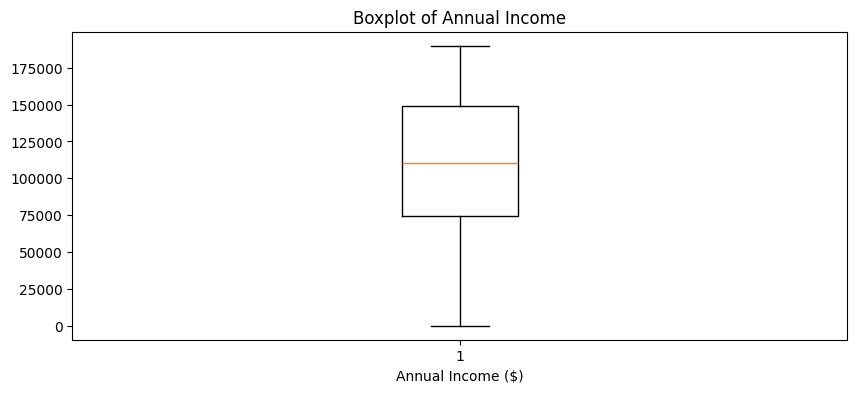

In [ ]:
pdf = df.select("Annual Income ($)").toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.boxplot(pdf["Annual Income ($)"])
plt.title("Boxplot of Annual Income")
plt.xlabel("Annual Income ($)")
plt.show()

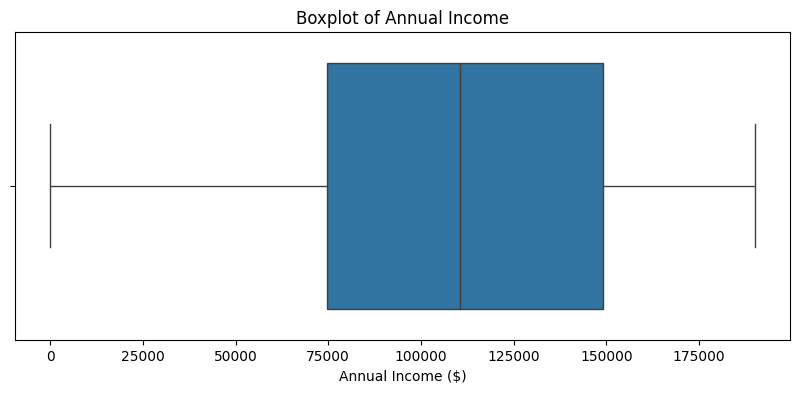

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
sns.boxplot(x=pdf["Annual Income ($)"])
plt.title("Boxplot of Annual Income")
plt.xlabel("Annual Income ($)")
plt.show()